# Theta

- Read about the [theta model](https://www.sciencedirect.com/science/article/abs/pii/S0169207000000662#:~:text=The%20method%20is%20based%20on,data%20but%20not%20their%20curvatures)
- See the [darts implementation](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.theta.html)
- See the [statsmodels implementation](https://www.statsmodels.org/devel/examples/notebooks/generated/theta-model.html#:~:text=The%20Theta%20model%20of%20Assimakopoulos,to%20produce%20the%20final%20forecast)
- Download data from [GitHub](https://github.com/Mcompetitions/M4-methods/tree/master/Dataset)
- Install darts: `pip install darts`
- See the [blog post](https://medium.com/towards-data-science/easily-employ-a-theta-model-for-time-series-b94465099a00)

Scalecast ports the model from darts, which is supposed to be more accurate and is also easier to maintain.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from scalecast.Forecaster import Forecaster
from scalecast.util import metrics
from scalecast import GridGenerator

In [2]:
train = pd.read_csv('Hourly-train.csv',index_col=0)
test = pd.read_csv('Hourly-test.csv',index_col=0)
y = train.loc['H7'].to_list()
current_dates = pd.date_range(start='2015-01-07 12:00',freq='H',periods=len(y)).to_list()

y_test = test.loc['H7'].to_list()

f = Forecaster(
    y=y,
    current_dates=current_dates,
    metrics = ['smape','r2'],
    test_length = .25,
    future_dates = len(y_test),
    cis = True,
)

f

Forecaster(
    DateStartActuals=2015-01-18T08:00:00.000000000
    DateEndActuals=2015-02-16T11:00:00.000000000
    Freq=H
    N_actuals=700
    ForecastLength=48
    Xvars=[]
    Differenced=0
    TestLength=240
    ValidationLength=1
    ValidationMetric=smape
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

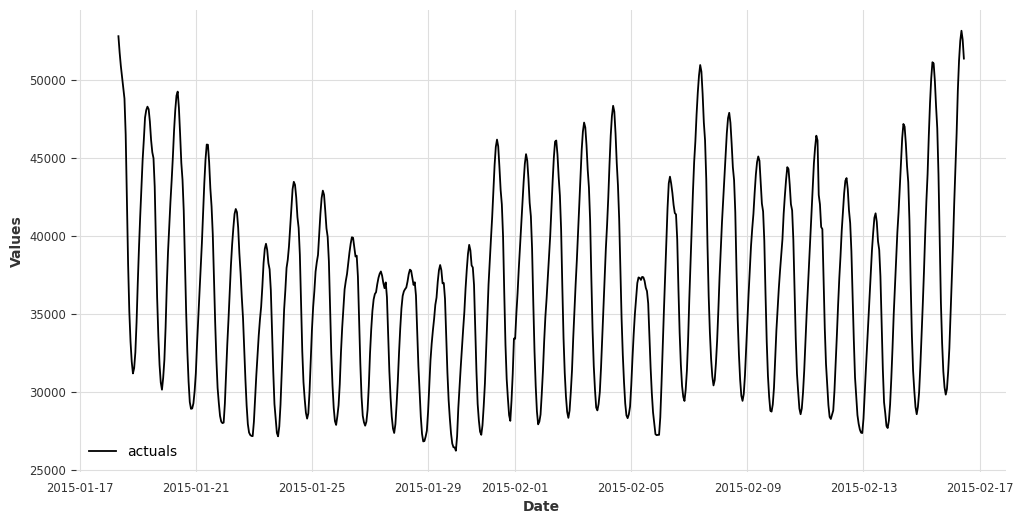

In [3]:
f.plot()
plt.show()

## Prepare forecast
- Download theta's validation grid

In [4]:
GridGenerator.get_grids('theta',out_name='Grids.py')
f.ingest_grid('theta')
f.grid.head()

,theta,model_mode,season_mode,trend_mode
0,0.5,ModelMode.ADDITIVE,SeasonalityMode.MULTIPLICATIVE,TrendMode.EXPONENTIAL
1,0.5,ModelMode.ADDITIVE,SeasonalityMode.MULTIPLICATIVE,TrendMode.LINEAR
2,0.5,ModelMode.ADDITIVE,SeasonalityMode.ADDITIVE,TrendMode.EXPONENTIAL
3,0.5,ModelMode.ADDITIVE,SeasonalityMode.ADDITIVE,TrendMode.LINEAR
4,0.5,ModelMode.MULTIPLICATIVE,SeasonalityMode.MULTIPLICATIVE,TrendMode.EXPONENTIAL


## Call the forecast
- tune hyperparemters with 3-fold time series cross validation

In [5]:
f.set_estimator('theta')
f.cross_validate(k=3)
f.auto_forecast()

## Visualize test results

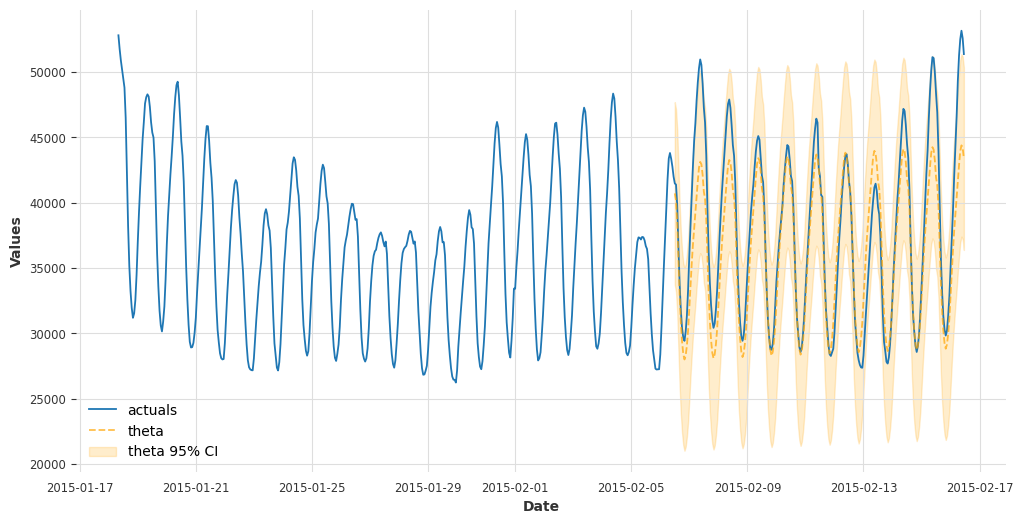

In [6]:
f.plot_test_set(ci=True)
plt.show()

## Visualize forecast results

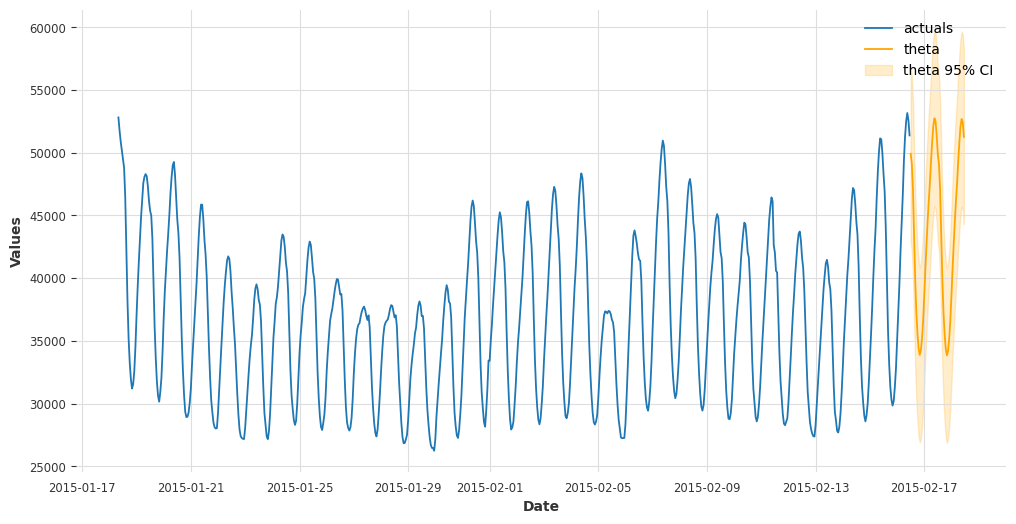

In [7]:
f.plot(ci=True)
plt.show()

## Which parameters were chosen from the grid search?

In [8]:
f.best_params

{'theta': 0.5,
 'model_mode': <ModelMode.ADDITIVE: 'additive'>,
 'season_mode': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>,
 'trend_mode': <TrendMode.EXPONENTIAL: 'exponential'>}

## See in-sample and out-of-sample accuracy/error metrics

In [9]:
results = f.export('model_summaries')

In [10]:
results[
    [
        'TestSetSMAPE',
        'InSampleSMAPE',
        'TestSetR2',
        'InSampleR2',
        'ValidationMetric',
        'ValidationMetricValue',
        'TestSetLength'
    ]
]

,TestSetSMAPE,InSampleSMAPE,TestSetR2,InSampleR2,ValidationMetric,ValidationMetricValue,TestSetLength
0,0.058274,0.014082,0.786943,0.984652,smape,0.064113,240


The validation metric displayed above is the average SMAPE across the three cross-validation folds.

In [11]:
validation_grid = f.export_validation_grid('theta')
validation_grid.head()

,theta,model_mode,season_mode,trend_mode,validation_length,validation_metric,metric_value,fold,rolling,train_length
0,0.5,ModelMode.ADDITIVE,SeasonalityMode.MULTIPLICATIVE,TrendMode.EXPONENTIAL,115,smape,0.056320,0,False,345
1,0.5,ModelMode.ADDITIVE,SeasonalityMode.MULTIPLICATIVE,TrendMode.LINEAR,115,smape,0.056510,0,False,345
2,0.5,ModelMode.ADDITIVE,SeasonalityMode.ADDITIVE,TrendMode.EXPONENTIAL,115,smape,0.055679,0,False,345
3,0.5,ModelMode.ADDITIVE,SeasonalityMode.ADDITIVE,TrendMode.LINEAR,115,smape,0.056044,0,False,345
4,0.5,ModelMode.MULTIPLICATIVE,SeasonalityMode.MULTIPLICATIVE,TrendMode.EXPONENTIAL,115,smape,0.056569,0,False,345


## Test the forecast against out-of-sample data
- this is data the `Forecaster` object has never seen

In [12]:
fcst = f.export('lvl_fcsts')
fcst.head()

,DATE,theta
0,2015-02-16 12:00:00,49921.533332
1,2015-02-16 13:00:00,49135.400143
2,2015-02-16 14:00:00,47126.062514
3,2015-02-16 15:00:00,43417.987575
4,2015-02-16 16:00:00,39867.287257


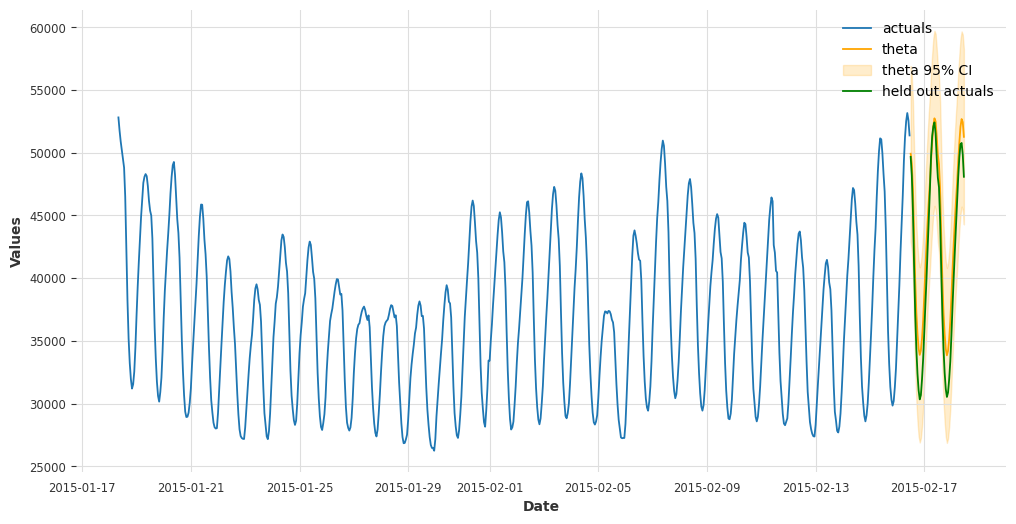

In [15]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ax=ax,ci=True)
sns.lineplot(
    x = f.future_dates, 
    y = y_test, 
    ax = ax, 
    label = 'held out actuals', 
    color = 'green',
)
plt.show()

In [14]:
smape = metrics.smape(y_test,fcst['theta'])
smape

0.05764507814606441